# Time series listing price

The data is comprised of Airbnb listings from Boston and Seattle. For each city a `calendar.csv`, a `listings.csv` and a `reviews.csv` is available. First we take a look at the general data structure from each of  `calendar.csv` files as an intial exploratory step.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

## Import internal modules
sys.path.append('..')
from src.config import config as cf
from src import data as dt

## matplotlib configurations
%matplotlib inline
plt.style.use('fivethirtyeight')



In [2]:
## Read .csv data
b_calendar = pd.read_csv(cf.data_dir.joinpath('raw').joinpath('boston_calendar.csv'))
s_calendar = pd.read_csv(cf.data_dir.joinpath('raw').joinpath('seattle_calendar.csv'))

b_calendar['city'] = 'Boston'
s_calendar['city'] = 'Seattle'

calendar = b_calendar.append(s_calendar, sort = False)

Now that we have consolidated the datasets for both cities, we take a look at **calendar** first.


The dataframe has in total 2702460 rows and 5 features.

There are the following number of features per type:

object    4
int64     1
dtype: int64

20.0% of the features have missing values


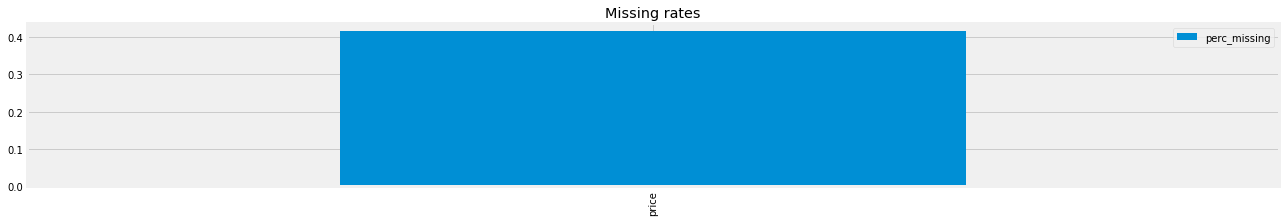

In [3]:
plt.rcParams['figure.figsize'] = (20,3)
dt.data_first_look(calendar)


## Data cleaning

Checking for missing values can be done for the whole consolidated dataset. However it might be that there are different no. of missing values per city

In [4]:
print("-- Proportion of NAs\n")
print(calendar.isnull().sum()/calendar.shape[0])

print("\n-- NAs per city on price column\n")
calendar.groupby(['city'])['price'].apply(lambda _df: _df.isnull().sum())
# df.groupby('a')['b', 'c'].apply(lambda _df: _df.isna().sum())

-- Proportion of NAs

listing_id    0.000000
date          0.000000
available     0.000000
price         0.416243
city          0.000000
dtype: float64

-- NAs per city on price column



city
Boston     665853
Seattle    459028
Name: price, dtype: int64

Almost half of all entries have missing prices being Boston the city with the most NAs. Even though removing entries with NAs would gratelly reduce the dataset, there is no way we could impute values in this column accuratelly and confidently. Therefore we remove entries with missing values.

In [5]:
calendar_cln = calendar.dropna(subset = ['price'], axis = 0)

We also observe some data type issues. First, we notice that the data type of the date column is wrong. Therefore we change it to date format.

In [18]:
## Reformat the dates column
todate = lambda val: pd.to_datetime(val)

calendar_cln.loc[:,'date'] = calendar_cln['date'].apply(todate)


Second, we observe that the price is declared as an object type and that the values contain a "$" sign. Therefore some transformations are needed.

In [7]:
calendar_cln.loc[:,'price'] = calendar_cln.loc[:,'price'].str.replace('$', '')
calendar_cln.loc[:,'price'] = pd.to_numeric(calendar_cln.loc[:,'price'], errors = 'coerce')

## Price as as time series

In order to be able to analyse the listings initial price, we need to aggregate the prices with a mean price per day per city measure.

In [8]:
avg_price = calendar_cln.groupby(['date','city'])['date','city','price'].mean().reset_index()
avg_price.head()

,date,city,price
0,2016-01-04,Seattle,122.085879
1,2016-01-05,Seattle,120.681307
2,2016-01-06,Seattle,120.928258
3,2016-01-07,Seattle,120.958896
4,2016-01-08,Seattle,127.640853


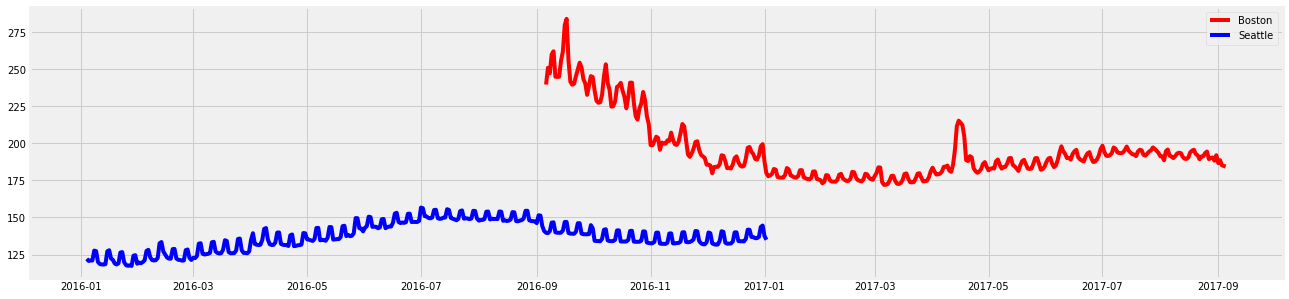

In [9]:
plt.figure(figsize = [20, 5]) 
plt.plot(avg_price.loc[avg_price['city'] == 'Boston']['date']
            , avg_price.loc[avg_price['city'] == 'Boston']['price']
            , color = "red"
            , label = 'Boston')
plt.plot(avg_price.loc[avg_price['city'] == 'Seattle']['date']
            , avg_price.loc[avg_price['city'] == 'Seattle']['price']
            , color = "blue"
            , label = 'Seattle')
plt.legend()
plt.show()


We observe that both time series begin in different points of time with at most 2 months overlap among them. Even though a simple direct inspection already provides us with the first insights, additional operations need to be made to be able to do a direct comparison. For this purpose we make use of a new colum containing the number of days since the first listing, i.e., observation days (respective to each city), and thus becoming a "normalized" time column.

In [10]:
start_date_boston = avg_price.loc[avg_price['city'] == 'Boston', 'date'].min()
start_date_seattle = avg_price.loc[avg_price['city'] == 'Seattle', 'date'].min()
print('Start of the observations in Boston:{}'.format(start_date_boston))
print('Start of the observations in Seattle:{}'.format(start_date_seattle))
avg_price['norm_days'] = np.where(avg_price['city']=="Boston",
                                 avg_price['date'] - start_date_boston,
                                 avg_price['date'] - start_date_seattle
                                 )
avg_price['norm_days'] = avg_price['norm_days'].dt.days.astype('int16')
# avg_price['delta'] = avg_price.loc[avg_price['city'] == 'Boston']['price'] - avg_price.loc[avg_price['city'] == 'Seattle']['price']

Start of the observations in Boston:2016-09-06 00:00:00
Start of the observations in Seattle:2016-01-04 00:00:00


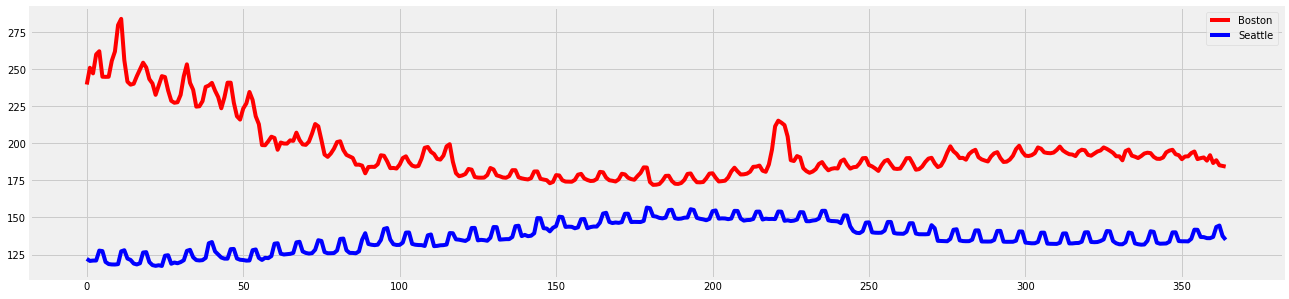

In [11]:
plt.figure(figsize = [20, 5]) 
plt.plot(avg_price.loc[avg_price['city'] == 'Boston']['norm_days']
            , avg_price.loc[avg_price['city'] == 'Boston']['price']
            , color = "red"
            , label = 'Boston')
plt.plot(avg_price.loc[avg_price['city'] == 'Seattle']['norm_days']
            , avg_price.loc[avg_price['city'] == 'Seattle']['price']
            , color = "blue"
            , label = 'Seattle')
plt.legend()
plt.show()

In [12]:
# pandas.pivot(data, index=None, columns=None, values=None)[source]
avg_price_w = avg_price.pivot(index = 'norm_days', columns = 'city', values = 'price').reset_index()
avg_price_w['delta'] = avg_price_w['Boston'] - avg_price_w['Seattle']


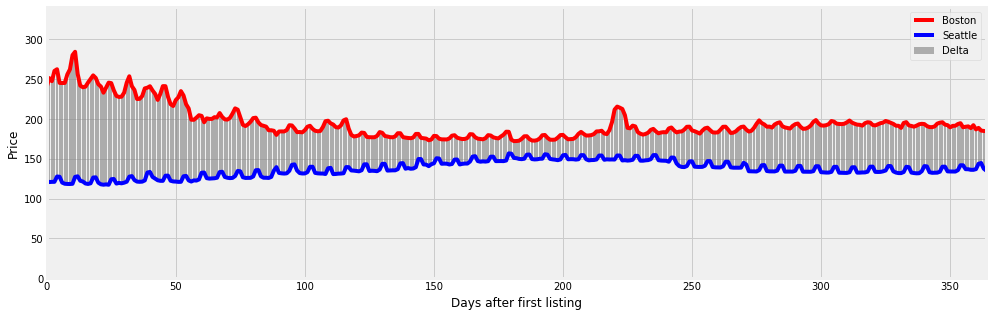

In [13]:
plt.figure(figsize = [15, 5]) 
plt.plot(avg_price_w['norm_days']
            , avg_price_w['Boston']
            , color = "red"
            , label = 'Boston')
plt.plot(avg_price_w['norm_days']
            , avg_price_w['Seattle']
            , color = "blue"
            , label = 'Seattle')
plt.bar(avg_price_w['norm_days']
        , height = avg_price_w['delta']
        ,  bottom = avg_price_w['Seattle']
        , color = "grey"
        , label = 'Delta'
        , alpha = 0.6)
plt.legend()
plt.xlim(0, avg_price['norm_days'].max())
plt.ylim(0, avg_price['price'].max() * 1.2)
plt.ylabel('Price')
plt.xlabel('Days after first listing')
plt.show()

Based on first visual interpretation of the data we can make the following observations:
* The listing prices in Boston are higher than in Seattle throughout the observation period.
* Overall the trends of these series have opposite behaviours, with, e.g., Seattle's prices peaking around after the first 180 observation days, whereas Boston's prices hit bottom at around the same time. 
* Boston's prices are more sensitive to time as it can be seen in the initial steep decline of the first 100 observation days.